In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
train_df = pd.read_csv('Ichijo_train.csv')
val_df = pd.read_csv('Ichijo_val.csv')
test_df = pd.read_csv('Ichijo_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(12280, 15) (3509, 15) (1755, 15)


## `DataWindow` class

変数一覧

1.   n_main_generation
2.   n_main_consumption
3.   n_main_buy
4.   n_main_sell
5.   n_main_generated_at_home
6.   n_hems_light
7.   n_hems_air_conditioner
8.   n_hems_eco_cute
9.   n_hems_ih
10.  n_hems_fridge
11.  n_hems_washing
12.  n_hems_ev








日にちの周期性がないと一定の値を吐き出すけど、周期性ありそうって言っても前日が0だったら全くもって意味ない、同じように0を吐き出すだけなのよね

今回はn_hems_eco_cute

In [ ]:
obj = 'n_main_generation'

class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
# ここを目的変数ごとに変更
    def plot(self, model=None, plot_col=obj, max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [ ]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=[obj])
#ここも目的関数に

### Repeat last value

In [ ]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [ ]:
#ここも目的関数に
baseline_last = MultiStepLastBaseline(label_index=column_indices[obj])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2157 - mean_absolute_error: 0.3381


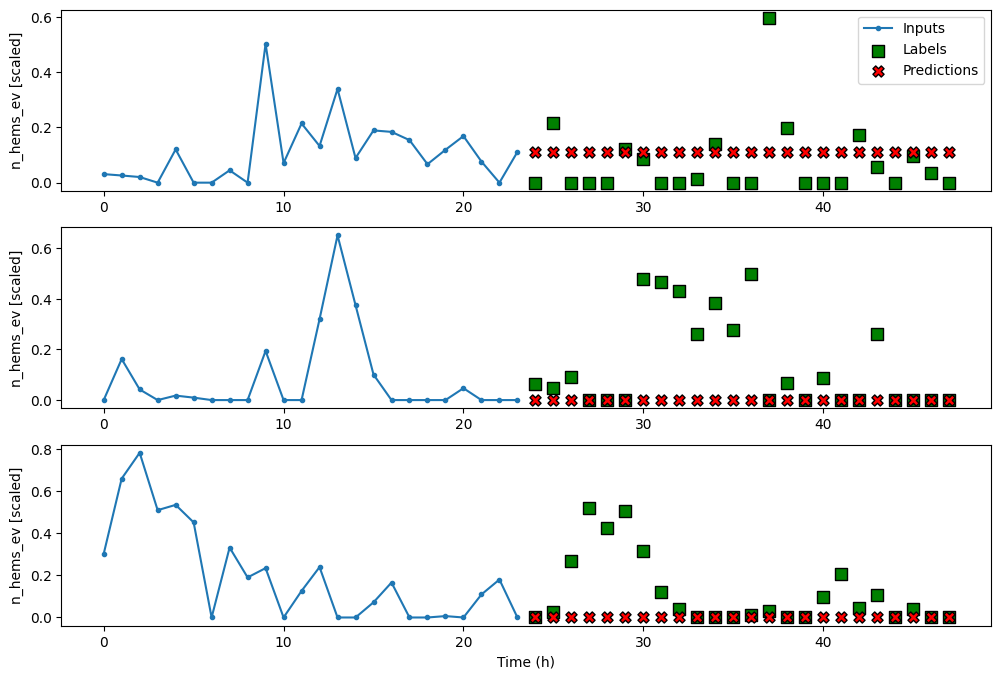

In [ ]:
multi_window.plot(baseline_last)

plt.savefig('figures/baseline_last.png', dpi=300)

### Repeat last day

In [ ]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [1]:
#ここも目的関数に

baseline_repeat = RepeatBaseline(label_index=column_indices[obj])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

NameError: name 'RepeatBaseline' is not defined

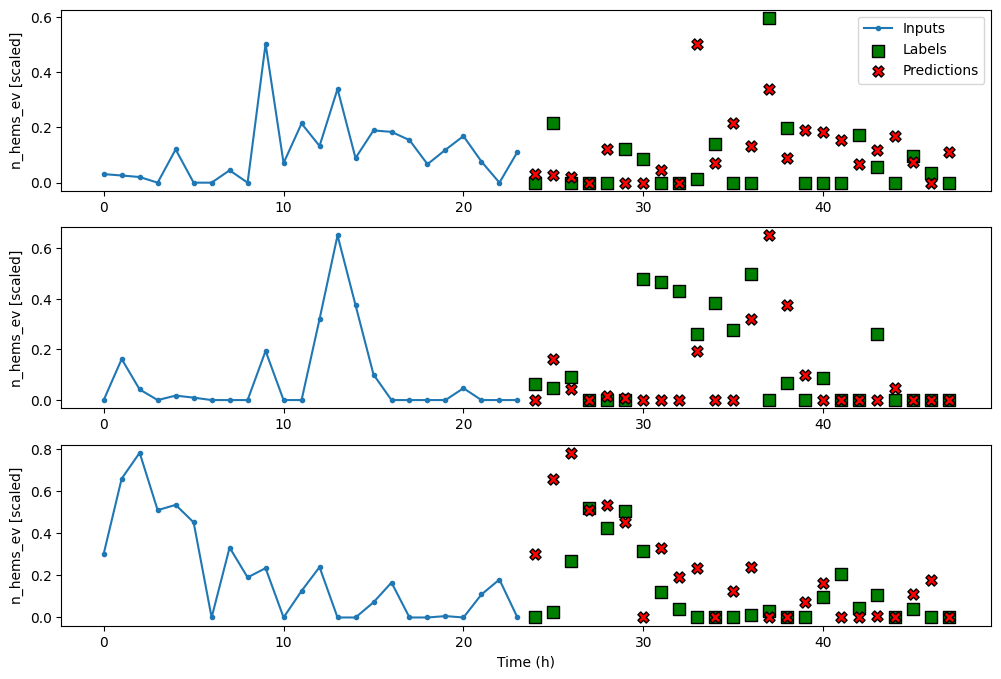

In [ ]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/baseline_repeat.png', dpi=300)

## Linear model

In [ ]:
#ここも目的関数に
label_index = column_indices[obj]
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2229 - mean_absolute_error: 0.6706 - val_loss: 0.0362 - val_mean_absolute_error: 0.1740
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0249 - mean_absolute_error: 0.1182 - val_loss: 0.0118 - val_mean_absolute_error: 0.0827
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0210 - mean_absolute_error: 0.1114 - val_loss: 0.0187 - val_mean_absolute_error: 0.1194
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0217 - mean_absolute_error: 0.1129 - val_loss: 0.4663 - val_mean_absolute_error: 0.6725
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1402 - mean_absolute_error: 0.2487 - val_loss: 0.3285 - val_mean_absolute_error: 0.5614
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3287 - mean_absolute_error: 0.5617


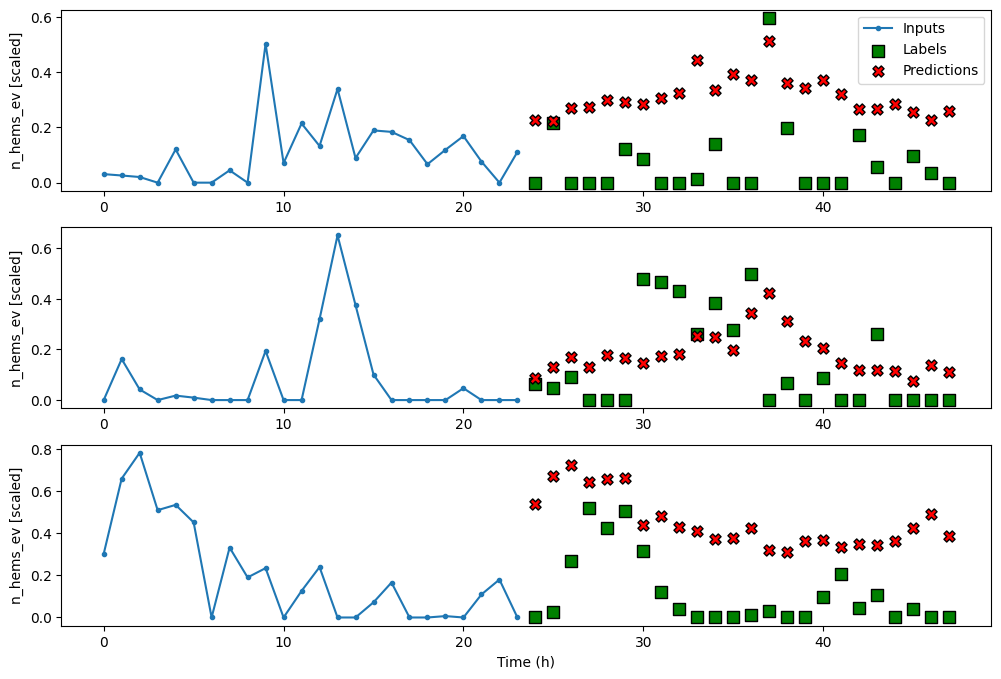

In [ ]:
multi_window.plot(linear)

plt.savefig('figures/linear.png', dpi=300)

## Dense model

In [ ]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 16.3743 - mean_absolute_error: 1.5296 - val_loss: 0.0382 - val_mean_absolute_error: 0.1791
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0336 - mean_absolute_error: 0.1311 - val_loss: 0.0303 - val_mean_absolute_error: 0.1585
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0334 - mean_absolute_error: 0.1312 - val_loss: 0.0286 - val_mean_absolute_error: 0.1536
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0329 - mean_absolute_error: 0.1311 - val_loss: 0.0159 - val_mean_absolute_error: 0.1077
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0326 - mean_absolute_error: 0.1313 - val_loss: 0.0461 - val_mean_absolute_error: 0.1982
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0320 - mean_absolute_error: 0.1318 - val_loss: 0.0393 - val_mean_absolute_error: 0.1821
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0322 - mean_absolute_error: 0.1332 

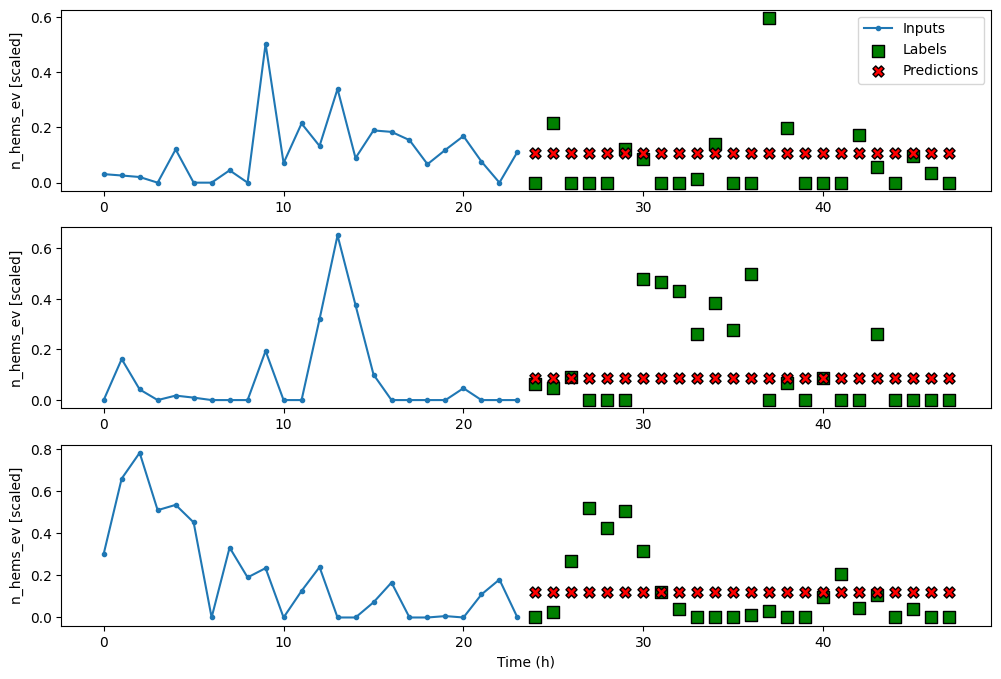

In [ ]:
multi_window.plot(dense)

plt.savefig('figures/Dense.png', dpi=300)

## LSTM model

In [ ]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0320 - mean_absolute_error: 0.1331 - val_loss: 0.0173 - val_mean_absolute_error: 0.1148
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0310 - mean_absolute_error: 0.1344 - val_loss: 0.0156 - val_mean_absolute_error: 0.1059
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0309 - mean_absolute_error: 0.1339 - val_loss: 0.0174 - val_mean_absolute_error: 0.1151
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0312 - mean_absolute_error: 0.1346 - val_loss: 0.0157 - val_mean_absolute_error: 0.1067
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0310 - mean_absolute_error: 0.1342 - val_loss: 0.0160 - val_mean_absolute_error: 0.1083
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0160 - mean_absolute_error: 0.1083


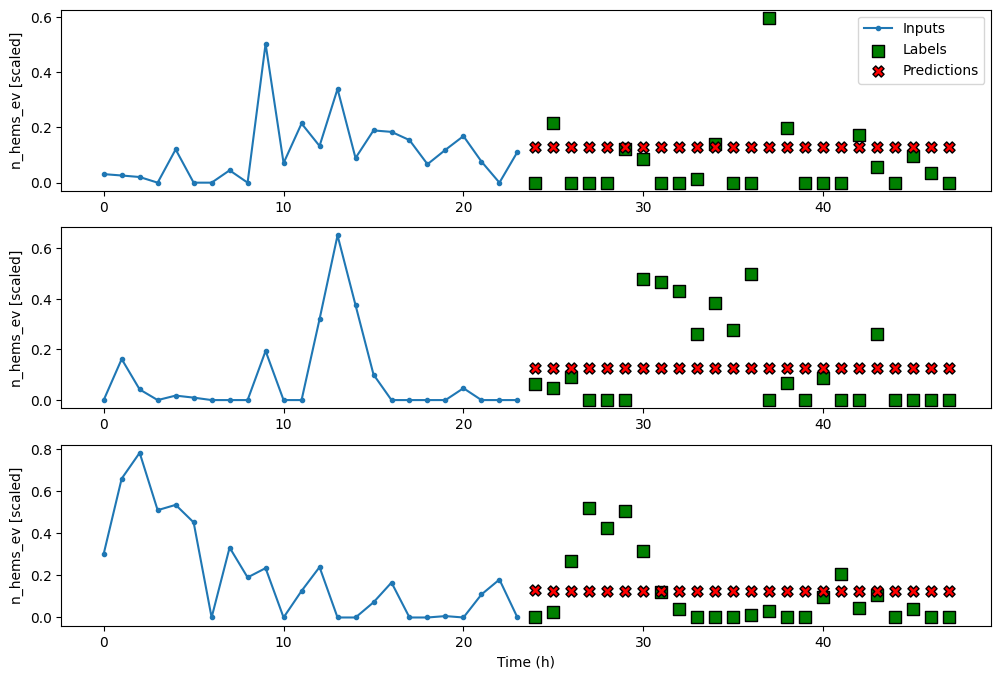

In [ ]:
multi_window.plot(lstm_model)

plt.savefig('figures/lstm.png', dpi=300)

## CNN model

In [ ]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=[obj])
#ここも目的関数に

In [ ]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6.4813 - mean_absolute_error: 1.0309 - val_loss: 0.0655 - val_mean_absolute_error: 0.2384
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2196 - mean_absolute_error: 0.2505 - val_loss: 0.0208 - val_mean_absolute_error: 0.1287
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1350 - mean_absolute_error: 0.2066 - val_loss: 0.0338 - val_mean_absolute_error: 0.1681
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0321 - mean_absolute_error: 0.1309 - val_loss: 0.0290 - val_mean_absolute_error: 0.1547
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0316 - mean_absolute_error: 0.1312 - val_loss: 0.0212 - val_mean_absolute_error: 0.1303
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - mean_absolute_error: 0.1306


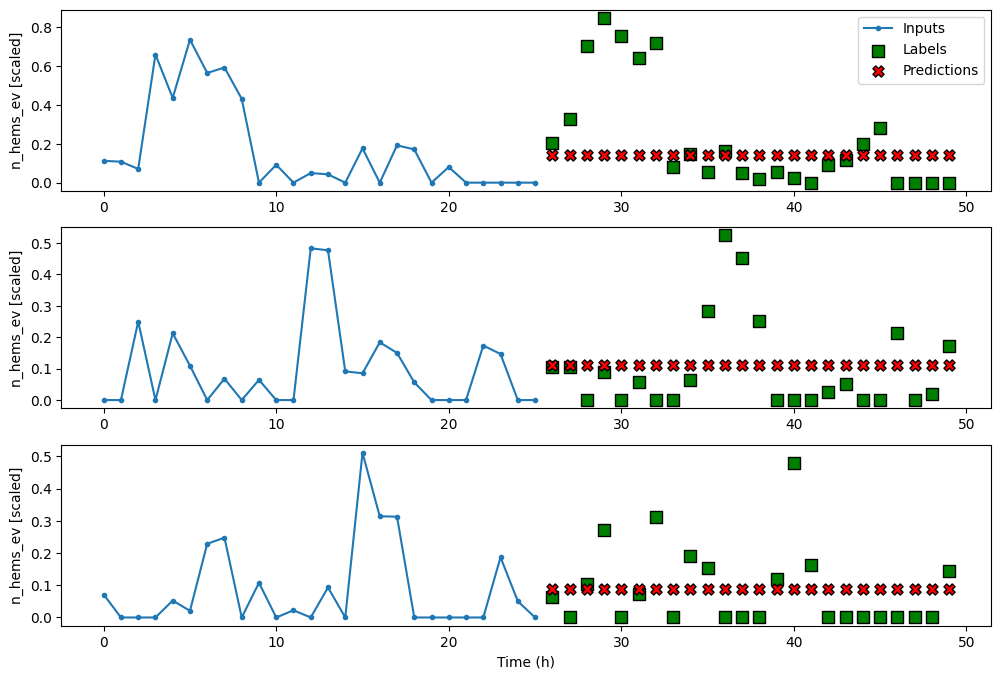

In [ ]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CNN.png', dpi=300)

## CNN + LSTM model

In [ ]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0321 - mean_absolute_error: 0.1334 - val_loss: 0.0160 - val_mean_absolute_error: 0.1083
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0311 - mean_absolute_error: 0.1346 - val_loss: 0.0154 - val_mean_absolute_error: 0.1048
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0313 - mean_absolute_error: 0.1348 - val_loss: 0.0151 - val_mean_absolute_error: 0.1031
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0311 - mean_absolute_error: 0.1345 - val_loss: 0.0155 - val_mean_absolute_error: 0.1054
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0310 - mean_absolute_error: 0.1346 - val_loss: 0.0156 - val_mean_absolute_error: 0.1060
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0309 - mean_absolute_error: 0.1345 - val_loss: 0.0160 - val_mean_absolute_error: 0.1083
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0161 - mean_absolute_error: 0.1086


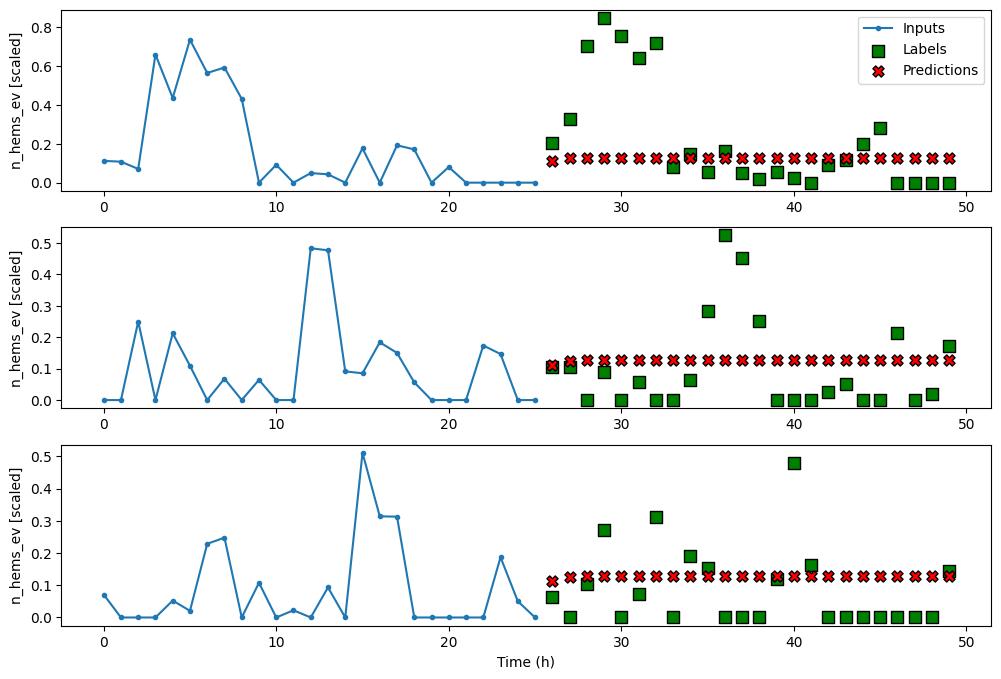

In [ ]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CNN+lstm.png', dpi=300)

## Autoregressive LSTM

In [ ]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [ ]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0400 - mean_absolute_error: 0.1460 - val_loss: 0.0158 - val_mean_absolute_error: 0.1071
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0312 - mean_absolute_error: 0.1348 - val_loss: 0.0158 - val_mean_absolute_error: 0.1073
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0312 - mean_absolute_error: 0.1348 - val_loss: 0.0159 - val_mean_absolute_error: 0.1075
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0312 - mean_absolute_error: 0.1349 - val_loss: 0.0158 - val_mean_absolute_error: 0.1072
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0158 - mean_absolute_error: 0.1072


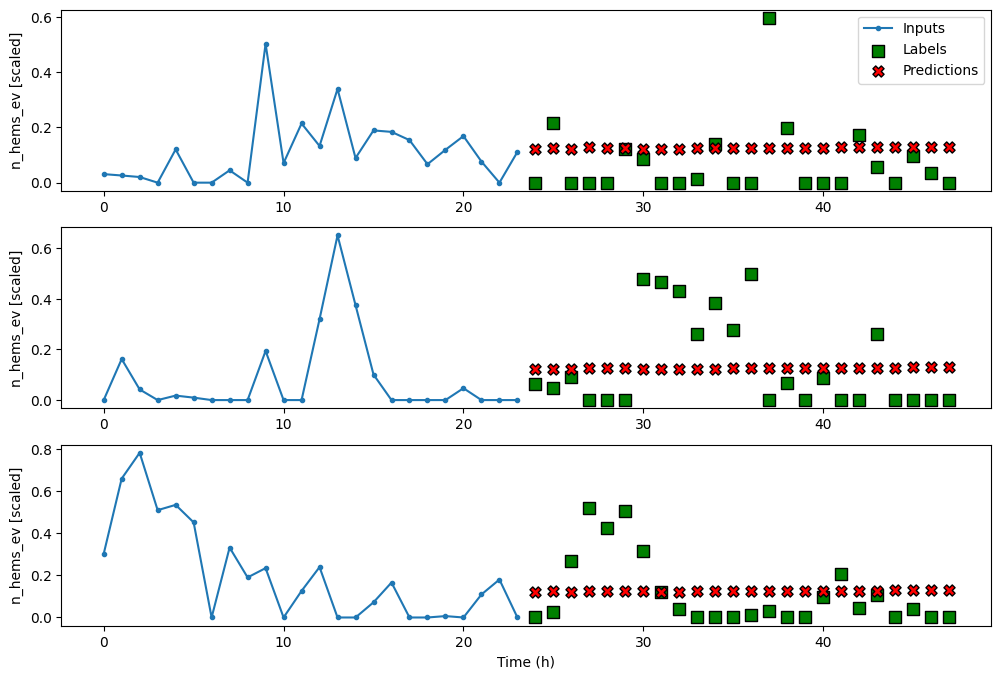

In [ ]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/AR_LSTM.png', dpi=300)

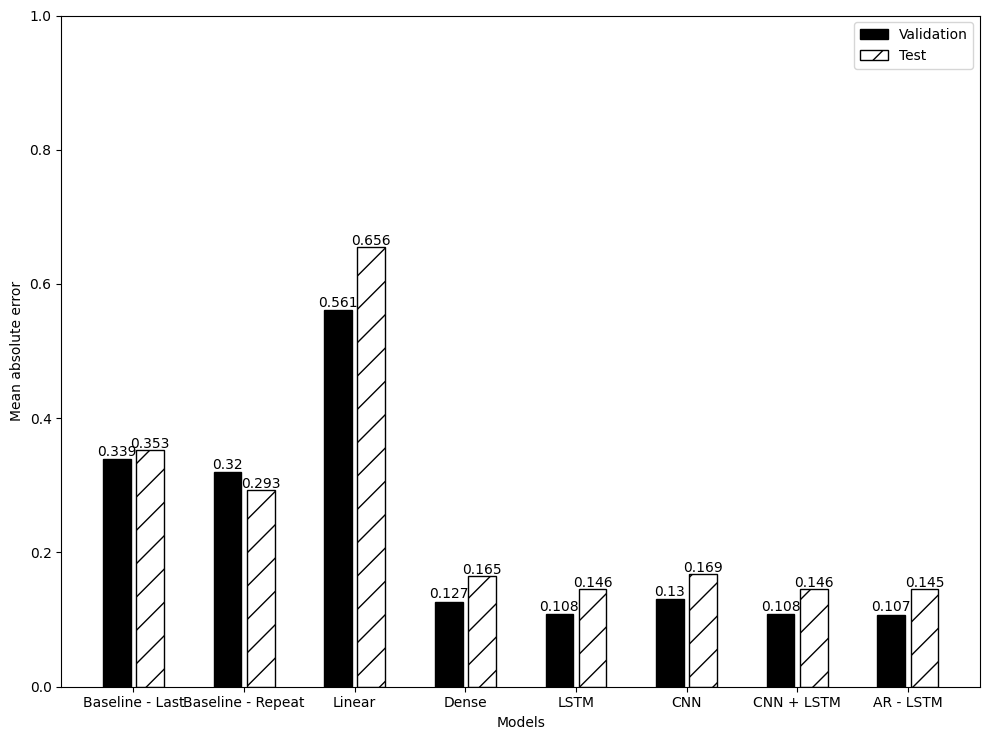

In [ ]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/Validation_Compersion.png', dpi=300)